In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

from IPython.display import display, HTML

In [122]:
def list_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

In [123]:
def most_recent_directory(directory):
    dirs = list_directories(directory)
    if not dirs:
        return None
    
    most_recent = max(dirs, key=lambda d: os.path.getctime(os.path.join(directory, d)))
    return os.path.join(directory, most_recent)

In [124]:
def mean_of_chunks(series, chunk_size):
    # Explicitly setting numeric_only to True to avoid FutureWarning about deprecation
    return series.groupby(np.arange(len(series)) // chunk_size).mean(numeric_only=True)

In [125]:
base_folder = ".."
path = f"{base_folder}/output/host/workload=bitbrains-small/seed=0/"

recent_dir = most_recent_directory(path)
simulation_files = os.listdir(recent_dir)

In [126]:
simulation_data = []

for file in simulation_files:
    simulation_data.append(
        mean_of_chunks(pd.read_parquet(os.path.join(recent_dir, file)), 1000)
    )

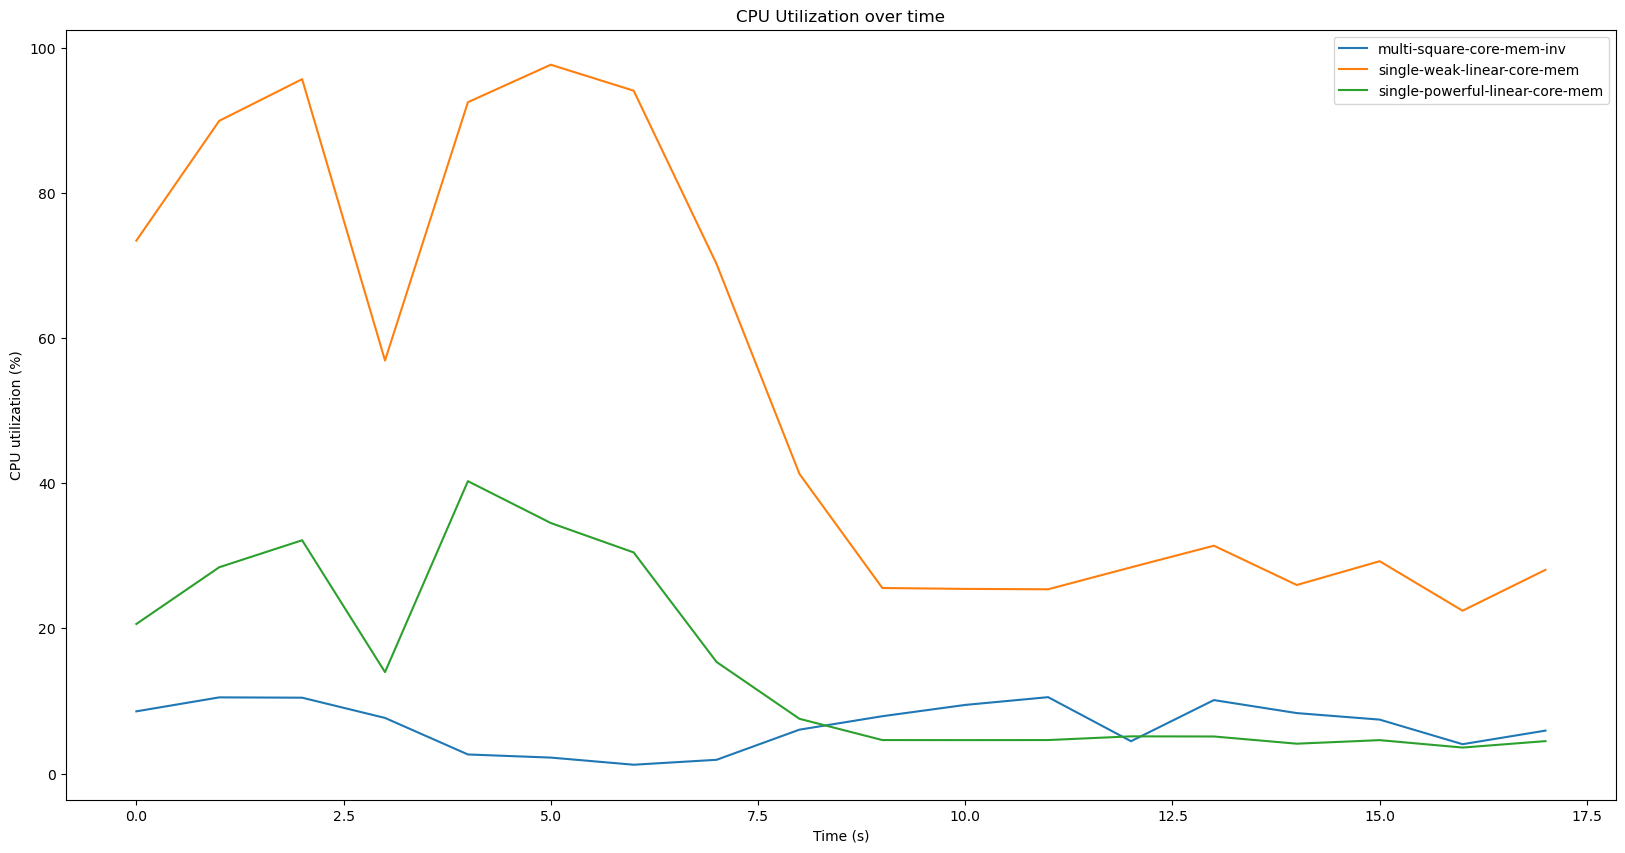

In [127]:
min_length = min([len(df) for df in simulation_data])
simulated_metrics = []

plt.figure(figsize=(20, 10))

for i in range(len(simulation_data)):
    df = simulation_data[i][:min_length]
    df = df.cpu_utilization * 100
    df_label = simulation_files[i].split(".")[0]
    df.plot(label=df_label)
    
plt.legend()
plt.title("CPU Utilization over time")
plt.xlabel("Time (s)")
plt.ylabel("CPU utilization (%)")
plt.show()